In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import pickle
import time
warnings.filterwarnings("ignore")

In [2]:
import torch
torch.cuda.empty_cache() # clear the GPU memory for efficient processing
np.random.seed(412)      # set global seed for random sampling

In [3]:
# init the VAE model:
model = scCube()

In [4]:
# read in the Wu reference
sc_ref = sc.read_h5ad("/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scRNA_ref_ERpos.h5ad")

In [5]:
sc_ref.raw.to_adata().obs.index

Index(['CID4461_AAACCTGAGCTAAGAT', 'CID4461_AAAGTAGGTACAGCAG',
       'CID4461_AAATGCCTCCGGCACA', 'CID4461_AAGACCTTCTGCTGTC',
       'CID4461_AAGCCGCGTACCGTAT', 'CID4461_ACACTGAAGAGATGAG',
       'CID4461_ACAGCCGAGGGCATGT', 'CID4461_ACATGGTCAGACGCTC',
       'CID4461_ACCAGTATCCGTCAAA', 'CID4461_ACGTCAACACCAGATT',
       ...
       'CID4398_TAGACCAAGCCCAGCT', 'CID4398_TAGTGGTTCGCAAACT',
       'CID4398_TAGTTGGAGGGAAACA', 'CID4398_TCAATCTAGCTCCTCT',
       'CID4398_TCAGGTAAGATCTGAA', 'CID4398_TCAGGTAGTACTCAAC',
       'CID4398_TCTATTGTCGCCATAA', 'CID4398_TCTTTCCCAGTAAGCG',
       'CID4398_TGCCCATGTTACGGAG', 'CID4398_TTGAACGTCCTATTCA'],
      dtype='object', length=38241)

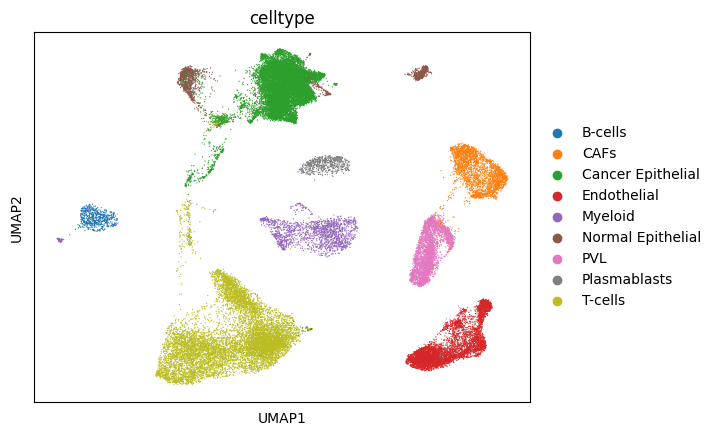

In [6]:
# reshaping the reference
sc_data = pd.DataFrame(sc_ref.raw.to_adata().X.toarray(), 
                       index=sc_ref.raw.to_adata().obs.index,    # Cell names
                       columns=sc_ref.raw.to_adata().var.index)  # Gene names
sc_meta = sc_ref.raw.to_adata().obs

# plot the ref UMAP
sc.pl.umap(sc_ref, color = "celltype")

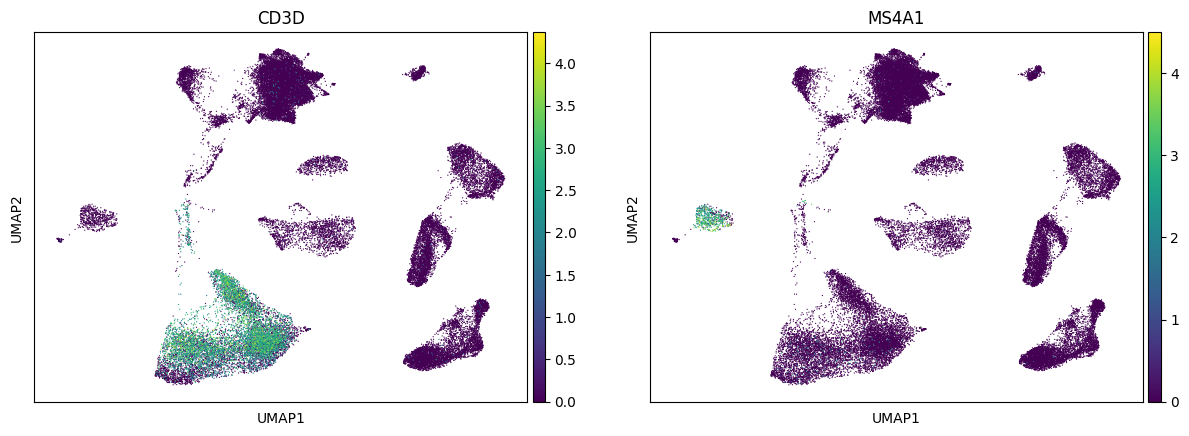

In [7]:
sc.pl.umap(
    sc_ref,
    color=["CD3D", "MS4A1"]
)

In [8]:
# Randomly downsample reference scRNAseq object to train the VAE
# while maintaining proportions of cell types

# Step 1: Calculate the number of cells for each cell type
celltype_counts = sc_meta['celltype'].value_counts()

# Step 2: Decide on the total number of cells you want in the downsampled matrix
total_cells_to_sample = 12000  # Set this to your desired total

# Step 3: Calculate the number of cells to sample from each cell type
proportions = celltype_counts / celltype_counts.sum()

# Recalculate based on adjusted proportions
proportions /= proportions.sum()  # Ensure proportions sum to 1
cells_to_sample = (proportions * total_cells_to_sample).round().astype(int)

# Adjust for any rounding issues by redistributing any excess samples
while cells_to_sample.sum() < total_cells_to_sample:
    cells_to_sample.loc[cells_to_sample.idxmax()] += 1
while cells_to_sample.sum() > total_cells_to_sample:
    cells_to_sample.loc[cells_to_sample.idxmin()] -= 1

# Step 4: Randomly sample the specified number of cells from each cell type
sampled_cells = []
for celltype, n_cells in cells_to_sample.items():
    cells = sc_meta[sc_meta['celltype'] == celltype]['X']
    sampled_cells.extend(np.random.choice(cells, size=n_cells, replace=False))

# Step 5: Create the downsampled matrices
downsampled_counts_df = sc_data.loc[sampled_cells, :]
downsampled_metadata_df = sc_meta[sc_meta['X'].isin(sampled_cells)]

# Result
print(downsampled_counts_df)
print(downsampled_metadata_df)


                           RP11-34P13.7  FO538757.3  FO538757.2  AP006222.2  \
CID3941_CCATGTCCACAGAGGT         0.0000         0.0    0.000000         0.0   
CID4530N_ATGTGTGTCCTACAGA        0.0000         0.0    0.000000         0.0   
CID4471_CTAGCCTGTATTCTCT         0.0000         0.0    0.000000         0.0   
CID4535_GCATACATCCGTACAA         0.3097         0.0    0.309700         0.0   
CID4535_TTAGTTCGTAAATGAC         0.0000         0.0    0.000000         0.0   
...                                 ...         ...         ...         ...   
CID3948_TGTGGTACACCTGGTG         0.0000         0.0    0.000000         0.0   
CID4040_ACGTAACCAGGCCCTA         0.0000         0.0    0.988074         0.0   
CID4040_GCAACCGCACTGCGTG         0.0000         0.0    0.000000         0.0   
CID4067_CGAACATGTCTAGTCA         0.0000         0.0    0.000000         0.0   
CID3941_GCATGTATCTCAACTT         0.0000         0.0    0.000000         0.0   

                           RP4-669L17.10  RP5-857K2

In [9]:
cells_to_sample

Cancer Epithelial    3727
T-cells              3082
Endothelial          1634
PVL                  1025
CAFs                  807
Normal Epithelial     763
Myeloid               575
Plasmablasts          198
B-cells               189
Name: celltype, dtype: int64

In [10]:
subset_cells = downsampled_metadata_df.index
subset_cells

Index(['CID4461_AAACCTGAGCTAAGAT', 'CID4461_AAATGCCTCCGGCACA',
       'CID4461_AAGACCTTCTGCTGTC', 'CID4461_ACACTGAAGAGATGAG',
       'CID4461_ACAGCCGAGGGCATGT', 'CID4461_ACATGGTCAGACGCTC',
       'CID4461_ACCAGTATCCGTCAAA', 'CID4461_ACTTGTTCAGTGGAGT',
       'CID4461_CAGAATCAGTGCTGCC', 'CID4461_CATATGGAGTCAAGGC',
       ...
       'CID4398_TTTCCTCAGAGGTAGA', 'CID4398_CAACCAACAGAGTGTG',
       'CID4398_AGTAGTCCAACGATCT', 'CID4398_ATCACGAAGTTCGCGC',
       'CID4398_ATGGGAGCAGGGTATG', 'CID4398_GGGTTGCGTACTCAAC',
       'CID4398_TAGACCAAGCCCAGCT', 'CID4398_TAGTTGGAGGGAAACA',
       'CID4398_TCAGGTAGTACTCAAC', 'CID4398_TCTTTCCCAGTAAGCG'],
      dtype='object', length=12000)

In [11]:
sc_meta['celltype'].value_counts()

Cancer Epithelial    11878
T-cells               9821
Endothelial           5206
PVL                   3265
CAFs                  2573
Normal Epithelial     2430
Myeloid               1831
Plasmablasts           631
B-cells                606
Name: celltype, dtype: int64

In [12]:
downsampled_metadata_df['celltype'].value_counts()

Cancer Epithelial    3727
T-cells              3082
Endothelial          1634
PVL                  1025
CAFs                  807
Normal Epithelial     763
Myeloid               575
Plasmablasts          198
B-cells               189
Name: celltype, dtype: int64

In [13]:
downsampled_counts_df

,RP11-34P13.7,FO538757.3,FO538757.2,AP006222.2,RP4-669L17.10,RP5-857K21.4,RP11-206L10.9,LINC00115,FAM41C,RP11-54O7.3,...,CTA-972D3.2,RP3-521E19.2,C7orf62,AC005008.2,MTNR1B,RP11-95I16.2,RP11-383C5.8,LINC01570,RP4-668E10.4,RP11-231E4.2
CID3941_CCATGTCCACAGAGGT,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID4530N_ATGTGTGTCCTACAGA,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID4471_CTAGCCTGTATTCTCT,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID4535_GCATACATCCGTACAA,0.3097,0.0,0.309700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID4535_TTAGTTCGTAAATGAC,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CID3948_TGTGGTACACCTGGTG,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID4040_ACGTAACCAGGCCCTA,0.0000,0.0,0.988074,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID4040_GCAACCGCACTGCGTG,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CID4067_CGAACATGTCTAGTCA,0.0000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Reorder the metadata to match the order of the cells in X
downsampled_metadata_df = downsampled_metadata_df.loc[downsampled_counts_df.index]
downsampled_counts_df.index == downsampled_metadata_df.index

array([ True,  True,  True, ...,  True,  True,  True])

In [16]:
sc_ref.obsm['X_umap']

array([[ 8.59575149, -9.34456878],
       [10.08678218, -9.00214057],
       [ 8.9248273 , -9.14846759],
       ...,
       [-0.2869736 , -1.11628168],
       [-0.29380356, -1.14744048],
       [-0.02449712, -0.9388514 ]])

In [17]:
sc_ref.obs_names.isin(downsampled_metadata_df.index)

array([ True, False,  True, ...,  True, False, False])

In [18]:
sc_ref.var_names

Index(['HES4', 'ISG15', 'RNF223', 'TNFRSF18', 'TNFRSF4', 'MXRA8', 'VWA1',
       'MMP23B', 'GABRD', 'TNFRSF9',
       ...
       'CLGN', 'STMN2', 'HS3ST2', 'FAM92B', 'PVALB', 'HAPLN1', 'OR51E1',
       'RP11-598F7.6', 'IBSP', 'CBLN4'],
      dtype='object', length=2000)

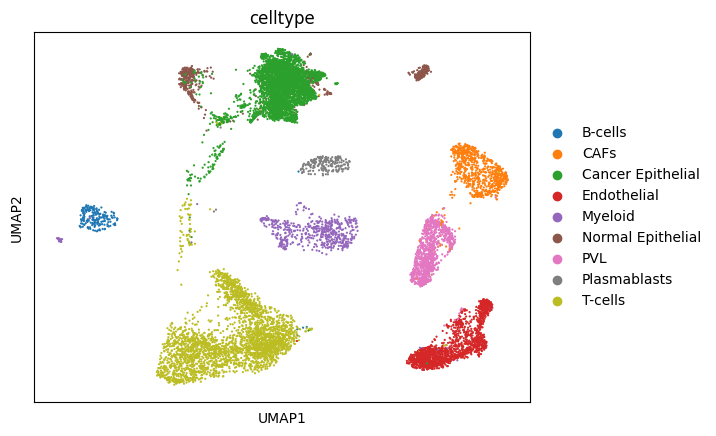

In [19]:
# Step 1: Align the indices of the downsampled cells with the reference object
matching_indices = sc_ref.obs_names.intersection(downsampled_metadata_df.index)

# Step 2: Reorder both metadata and UMAP embeddings to exactly match the downsampled indices
downsampled_metadata_df = downsampled_metadata_df.loc[matching_indices]
downsampled_umap_embeddings = sc_ref.obsm['X_umap'][sc_ref.obs_names.get_indexer(matching_indices), :]

# Step 3: Create the new AnnData object with correctly aligned data
downsampled_adata = sc.AnnData(
    X=downsampled_counts_df.loc[matching_indices],  # Ensure counts are in the correct order
    obs=downsampled_metadata_df  # Aligned metadata
)

# Step 4: Assign the reordered UMAP embeddings
downsampled_adata.obsm['X_umap'] = downsampled_umap_embeddings

# Step 5: Verify and plot
sc.pl.umap(downsampled_adata, color='celltype')  # Adjust 'celltype' to your metadata column name


In [20]:
downsampled_adata.var_names

Index(['RP11-34P13.7', 'FO538757.3', 'FO538757.2', 'AP006222.2',
       'RP4-669L17.10', 'RP5-857K21.4', 'RP11-206L10.9', 'LINC00115', 'FAM41C',
       'RP11-54O7.3',
       ...
       'CTA-972D3.2', 'RP3-521E19.2', 'C7orf62', 'AC005008.2', 'MTNR1B',
       'RP11-95I16.2', 'RP11-383C5.8', 'LINC01570', 'RP4-668E10.4',
       'RP11-231E4.2'],
      dtype='object', length=27719)

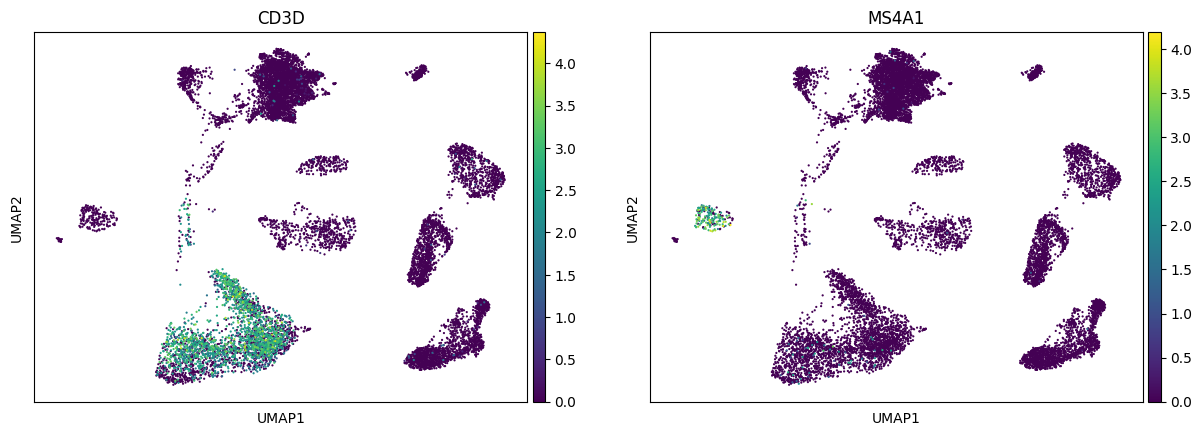

In [21]:
sc.pl.umap(
    downsampled_adata,
    color=["CD3D", "MS4A1"]
)

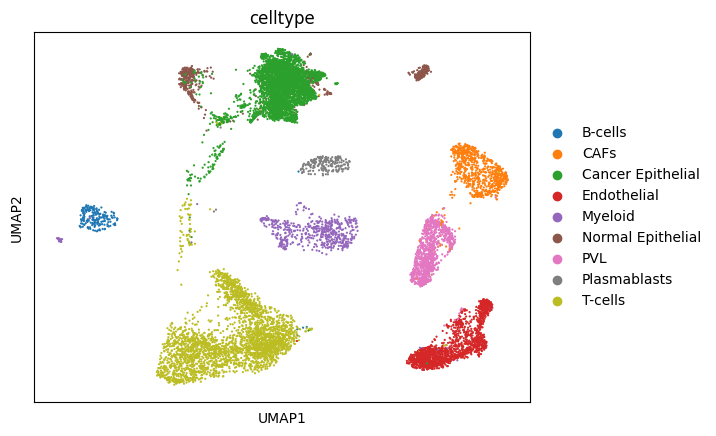

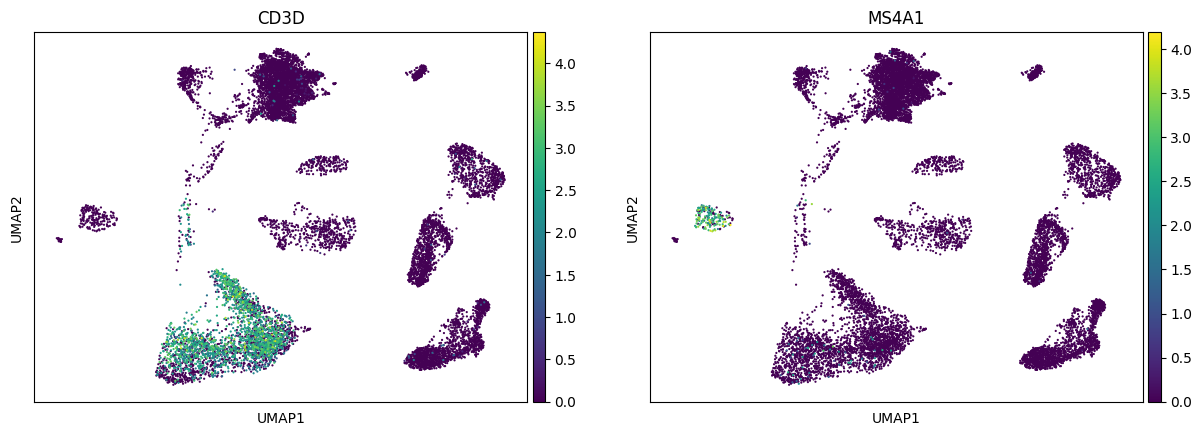

In [22]:
# Pre-processing the downsampled ER+ reference dataset 
sc_adata = model.pre_process(sc_data=downsampled_counts_df.loc[matching_indices].transpose(), 
                             sc_meta=downsampled_metadata_df,
                             is_normalized=True)
# Step 4: Assign the reordered UMAP embeddings
sc_adata.obsm['X_umap'] = downsampled_umap_embeddings

# Step 5: Verify and plot
sc.pl.umap(sc_adata, color='celltype')  # Adjust 'celltype' to your metadata column name
sc.pl.umap(
    sc_adata,
    color=["CD3D", "MS4A1"]
)

In [23]:
sc_adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,X,percent.mito,subtype,celltype_subset,celltype_minor,celltype_major,patient_ID,celltype,tissue,RNA_snn_res.0.8,seurat_clusters
CID4461_AAACCTGAGCTAAGAT,CID4461,712.0,504,CID4461_AAACCTGAGCTAAGAT,3.370787,ER+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,CID4461,Endothelial,Cancer,3,3
CID4461_AAATGCCTCCGGCACA,CID4461,2091.0,1180,CID4461_AAATGCCTCCGGCACA,4.830225,ER+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,CID4461,Endothelial,Cancer,3,3
CID4461_AAGACCTTCTGCTGTC,CID4461,435.0,303,CID4461_AAGACCTTCTGCTGTC,2.298851,ER+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,CID4461,Endothelial,Cancer,3,3
CID4461_ACACTGAAGAGATGAG,CID4461,588.0,395,CID4461_ACACTGAAGAGATGAG,7.482993,ER+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,CID4461,Endothelial,Cancer,3,3
CID4461_ACAGCCGAGGGCATGT,CID4461,354.0,264,CID4461_ACAGCCGAGGGCATGT,7.627119,ER+,Endothelial ACKR1,Endothelial ACKR1,Endothelial,CID4461,Endothelial,Cancer,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CID4398_GGGTTGCGTACTCAAC,CID4398,6081.0,1074,CID4398_GGGTTGCGTACTCAAC,2.006249,ER+,Myeloid_c0_DC_LAMP3,DCs,Myeloid,CID4398,Myeloid,Cancer,15,15
CID4398_TAGACCAAGCCCAGCT,CID4398,2134.0,575,CID4398_TAGACCAAGCCCAGCT,11.621368,ER+,Myeloid_c0_DC_LAMP3,DCs,Myeloid,CID4398,Myeloid,Cancer,15,15
CID4398_TAGTTGGAGGGAAACA,CID4398,6036.0,1122,CID4398_TAGTTGGAGGGAAACA,3.247184,ER+,Myeloid_c0_DC_LAMP3,DCs,Myeloid,CID4398,Myeloid,Cancer,15,15
CID4398_TCAGGTAGTACTCAAC,CID4398,6189.0,1251,CID4398_TCAGGTAGTACTCAAC,2.698336,ER+,Myeloid_c0_DC_LAMP3,DCs,Myeloid,CID4398,Myeloid,Cancer,15,15


In [ ]:
generate_sc_meta, generate_sc_data = model.train_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='celltype',
    cell_key='X',
    target_num= None, # target number of cells to generate, if `target_num=None`, generate cells by the proportion of cell types of the input data
    batch_size=512,
    epoch_num=10000,
    lr=0.0001,
    hidden_size=128,
    save_model=True,
    save_path = "/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models",
    project_name = "Wu_scCube_large",
    used_device='cuda')

generating by the proportion of cell types of the input scRNA-seq data...
begin vae training...


Train Epoch: 4343:  43%|████▎     | 4344/10000 [1:21:06<1:45:03,  1.11s/it, loss=0.8225, min_loss=0.8212]

In [24]:
import pandas as pd
import numpy as np

# Function to simulate CITE data from spot-level ST data
def simulate_cite_seq_data(spot_index, cell_type_proportions, cell_type_profiles, num_proteins=100, num_ct_proteins=2):
    """Simulate spatial CITE-seq data with cell type-specific markers and background expression."""

    # Initialize the DataFrame for simulated protein expression, using only the specified number of markers per cell type
    protein_markers = [
        marker for cell_type, markers in cell_type_profiles.items()
        for marker in markers["Major"][:num_ct_proteins]
    ]
    protein_expression = pd.DataFrame(index=protein_markers, columns=spot_index['spot'].unique())
    
    # Iterate over each spot
    for spot_id in spot_index['spot'].unique():
        # Get the cell type proportions for the current spot
        proportions = cell_type_proportions.loc[spot_id]
        
        # Calculate average expression for each cell type
        avg_expressions = proportions * np.random.uniform(20, 50, size=len(proportions))
        
        # Simulate expression for each cell type marker
        for cell_type, markers in cell_type_profiles.items():
            cell_type_markers = markers["Major"][:num_ct_proteins]  # Limit to `num_ct_proteins` markers
            proportion = proportions.get(cell_type, 0)
            
            if proportion > 0:
                # Simulate expression for the markers with dropouts
                dropouts = np.random.rand(len(cell_type_markers)) < 0.05  # 5% chance of dropout
                simulated_counts = np.random.negative_binomial(avg_expressions[cell_type], 0.5, size=len(cell_type_markers))
                protein_expression.loc[cell_type_markers, spot_id] = np.where(dropouts, 0, simulated_counts)
            else:
                # Simulate low-level background expression
                low_background = np.random.negative_binomial(1, 0.5, size=len(cell_type_markers))
                protein_expression.loc[cell_type_markers, spot_id] = low_background

    # Simulate expression for remaining proteins as background noise
    remaining_proteins = [f'Nonspecific_Protein_{i+1}' for i in range(num_proteins - len(protein_markers))]
    for protein in remaining_proteins:
        protein_expression.loc[protein] = np.random.negative_binomial(10, 0.5, size=len(protein_expression.columns))

    return protein_expression

In [25]:
# function to simulate ST data from scRNA-seq reference data
def generate_spatial_samples_with_cite_seq(model, sc_adata, cell_type_profiles, num_samples=5, generate_cell_num=5000, spatial_size=50, num_proteins=100, num_ct_proteins=2):
    np.random.seed(412)
    
    # Init sample lists
    sc_samples = []
    st_samples = []
    cite_seq_samples = []

    # Fixed parameters
    shape_list = ['Irregular'] * 9
    cluster_purity_list   = [0.4, 0.5, 0.55, 0.5, 0.4, 0.5, 0.8, 0.7, 0.7]
    cluster_celltype_list = ['B-cells', 'CAFs', 'PVL', 'Plasmablasts', 'T-cells', 
                             'Myeloid', 'Cancer Epithelial', 'Normal Epithelial', 'Endothelial']
    infiltration_celltype_list = [
        ['Cancer Epithelial', 'T-cells'],
        ['Cancer Epithelial', 'Myeloid', 'T-cells'],
        ['T-cells', 'B-cells', 'Myeloid'],
        ['T-cells', 'Myeloid'],
        ['Cancer Epithelial', 'Myeloid'],
        ['Cancer Epithelial', 'T-cells'],
        ['T-cells', 'B-cells', 'CAFs'],
        ['Cancer Epithelial', 'T-cells', 'CAFs'],
        ['Cancer Epithelial', 'T-cells', 'CAFs']
    ]
    infiltration_prop_list = [
        [0.75, 0.25],
        [0.6, 0.3, 0.1],
        [0.5, 0.3, 0.2],
        [0.6, 0.4],
        [0.6, 0.4],
        [0.5, 0.5],
        [0.6, 0.3, 0.1],
        [0.5, 0.3, 0.2],
        [0.5, 0.35, 0.15]
    ]
    background_celltype = ['Cancer Epithelial', 'CAFs', 'B-cells', 'Myeloid', 'T-cells']
    background_prop = [0.5, 0.35, 0.05, 0.1, 0.1]
    a_list = [12, 10, 10, 10, 10, 10, 12, 12, 12]
    b_list = a_list.copy()
    scale_value_list = [4] * 9
    twist_value_list = [0.2] * 9

    # generate lists of simulated samples
    for i in range(num_samples):
        center_x_list = np.random.randint(0, 60, size=9).tolist()
        center_y_list = np.random.randint(0, 60, size=9).tolist()
        theta_list = [np.random.uniform(0, 2 * np.pi) for _ in range(9)]
        seed = 412 + i # different (non-random) seed for each sample

        sc_adata.obs['Cell_type'] = sc_adata.obs['celltype']
        sc_adata.obs['Cell']      = sc_adata.obs['X']

        # generate spatial patterns for each sample
        sc_meta, sc_data = model.generate_pattern_custom_cluster(
            sc_adata = sc_adata,
            generate_cell_num = generate_cell_num,
            celltype_key = 'Cell_type',
            cell_key = 'Cell',
            set_seed = True,
            seed     = seed,
            spatial_size = spatial_size,
            shape_list   = shape_list,

            infiltration_celltype_list = infiltration_celltype_list,
            infiltration_prop_list = infiltration_prop_list,
            background_celltype    = background_celltype,
                        cluster_celltype_list  = cluster_celltype_list,
            cluster_purity_list    = cluster_purity_list,
            background_prop = background_prop,
            center_x_list  = center_x_list,
            center_y_list  = center_y_list,
            a_list = a_list,
            b_list = b_list,
            theta_list = theta_list,
            scale_value_list = scale_value_list,
            twist_value_list = twist_value_list,
            hidden_size = 128,
            load_path   = '/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth',
            used_device = 'cuda'
        )

        # save single-cell resolution data to csv
        sc_meta.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/replicates/SC_sim/Wu_SC_{i}_meta.csv")
        sc_data.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/replicates/SC_sim/Wu_SC_{i}_data.csv")
        sc_samples.append((sc_meta, sc_data))

        # generate spot-level information for samples
        st_data, st_meta, st_index = model.generate_spot_data_random(
            generate_sc_data=sc_data,
            generate_sc_meta=sc_meta,
            platform='Visium',
            gene_type='whole',
            n_cell=5
        )

        # Calculate cell type proportions
        st_prop = calculate_spot_prop(
            obj=st_index,
            cell_id='Cell',
            label='Cell_type',
            spot_id='spot'
        )

        # Add missing cell types to proportions
        all_cell_types = cluster_celltype_list
        
        # Loop through each cell type and add missing ones with 0s
        for cell_type in all_cell_types:
            if cell_type not in st_prop.columns:
                # Create a Series of 0s with the same length as the number of rows in prop_1
                zeros_series = pd.Series([0.0] * len(st_prop), index=st_prop.index, dtype=float)
                # Insert the new column before 'spot_x'
                st_prop.insert(st_prop.columns.get_loc('spot_x'), cell_type, zeros_series)
                
        # write simulated spatial data to csv
        st_meta.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/replicates/ST_sim/Wu_ST_{i}_meta.csv")
        st_data.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/replicates/ST_sim/Wu_ST_{i}_data.csv")
        st_index.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/replicates/ST_sim/Wu_ST_{i}_index.csv")
        st_prop.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/replicates/ST_sim/Wu_ST_{i}_prop.csv")
        st_samples.append((st_meta, st_data, st_index, st_prop))
        
        # simulate CITE-seq data for each sample, passing cell_type_profiles as a parameter
        cite_seq_data = simulate_cite_seq_data(
            st_index, 
            st_prop,
            num_proteins=num_proteins, 
            num_ct_proteins=num_ct_proteins,
            cell_type_profiles=cell_type_profiles
        )
        cite_seq_data.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/replicates/CITE_sim/Wu_CITE_{i}_data.csv")
        cite_seq_samples.append(cite_seq_data)


    return sc_samples, st_samples, cite_seq_samples


In [26]:
cell_type_profiles = {
    "B-cells": {
        "Major": ["B-cells_Protein_1", "B-cells_Protein_2"]
    },
    "CAFs": {
        "Major": ["CAFs_Protein_1", "CAFs_Protein_2"]
    },
    "Cancer Epithelial": {
        "Major": ["Cancer Epithelial_Protein_1", "Cancer Epithelial_Protein_2"]
    },
    "Endothelial": {
        "Major": ["Endothelial_Protein_1", "Endothelial_Protein_2"]
    },
    "Myeloid": {
        "Major": ["Myeloid_Protein_1", "Myeloid_Protein_2"]
    },
    "Normal Epithelial": {
        "Major": ["Normal Epithelial_Protein_1", "Normal Epithelial_Protein_2"]
    },
    "PVL": {
        "Major": ["PVL_Protein_1", "PVL_Protein_2"]
    },
    "Plasmablasts": {
        "Major": ["Plasmablasts_Protein_1", "Plasmablasts_Protein_2"]
    },
    "T-cells": {
        "Major": ["T-cells_Protein_1", "T-cells_Protein_2"]
    }
}

# generating simulated spatial data
sc_samples, st_samples, cite_seq_samples = generate_spatial_samples_with_cite_seq(
    model, 
    sc_adata, 
    num_samples=5,
    cell_type_profiles=cell_type_profiles
)

generating structured cluster spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:02<00:00, 2128.25it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating structured cluster spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:00<00:00, 12607.03it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating structured cluster spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:00<00:00, 12921.86it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating structured cluster spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:00<00:00, 12508.97it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating structured cluster spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:00<00:00, 12683.50it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...


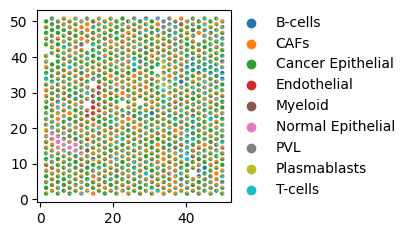

In [51]:
import matplotlib.pyplot as plt

# Define your 9 cell types and corresponding colors
cell_type_colors = {
    'B-cells': '#1f77b4',            # Blue
    'CAFs': '#ff7f0e',               # Orange
    'Cancer Epithelial': '#2ca02c',  # Green
    'Endothelial': '#d62728',        # Red
    'Myeloid': '#8c564b',       	 # Brown
    'Normal Epithelial': '#e377c2',  # Pink
    'PVL': '#7f7f7f',  				 # Grey
    'Plasmablasts': '#bcbd22',       # Yellow
    'T-cells': '#17becf'             # Cyan
}

plot_spot_scatterpie(
    obj=st_samples[0][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    size=10,
    edgecolor="none")
plt.show()

<AxesSubplot: >

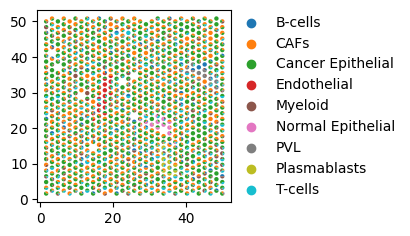

In [52]:
plot_spot_scatterpie(
    obj=st_samples[1][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    direction="+",
    start=0.0,
    size=10,
    edgecolor="none")

<AxesSubplot: >

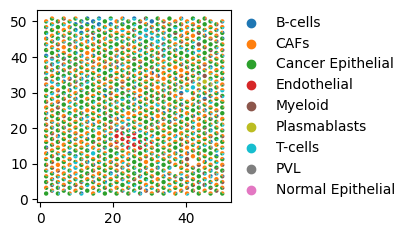

In [53]:
plot_spot_scatterpie(
    obj=st_samples[2][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    direction="+",
    start=0.0,
    size=10,
    edgecolor="none")

<AxesSubplot: >

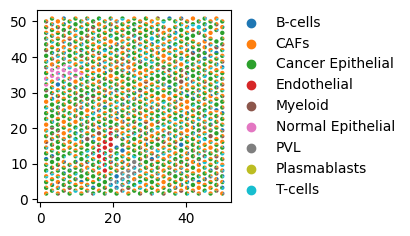

In [54]:
plot_spot_scatterpie(
    obj=st_samples[3][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    direction="+",
    start=0.0,
    size=10,
    edgecolor="none")

<AxesSubplot: >

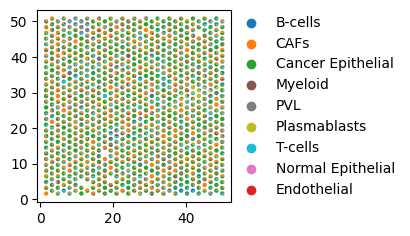

In [55]:
plot_spot_scatterpie(
    obj=st_samples[4][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    direction="+",
    start=0.0,
    size=10,
    edgecolor="none")

In [56]:
# Dictionary to store cell type counts for each sample
cell_type_counts_all_samples = {}

# Loop over the first 5 samples in st_samples
for i in range(5):
    # Get cell type counts for the current sample
    cell_type_counts = st_samples[i][2]['Cell_type'].value_counts()
    
    # Store the counts in the dictionary with the sample index as the key
    cell_type_counts_all_samples[f'Sample_{i}'] = cell_type_counts

# Display the cell type counts for all samples
for sample, counts in cell_type_counts_all_samples.items():
    print(f"{sample} cell type counts:")
    print(counts)
    print()  # New line for readability

Sample_0 cell type counts:
Cancer Epithelial    2175
CAFs                 1485
T-cells               491
Myeloid               456
B-cells               246
Normal Epithelial      52
Endothelial            38
Plasmablasts           34
PVL                    23
Name: Cell_type, dtype: int64

Sample_1 cell type counts:
Cancer Epithelial    2165
CAFs                 1509
T-cells               473
Myeloid               464
B-cells               220
Endothelial            48
Normal Epithelial      45
PVL                    41
Plasmablasts           35
Name: Cell_type, dtype: int64

Sample_2 cell type counts:
Cancer Epithelial    2209
CAFs                 1513
T-cells               498
Myeloid               456
B-cells               249
Endothelial            48
Plasmablasts           27
Name: Cell_type, dtype: int64

Sample_3 cell type counts:
Cancer Epithelial    2184
CAFs                 1528
T-cells               467
Myeloid               443
B-cells               225
Normal Epithelial  

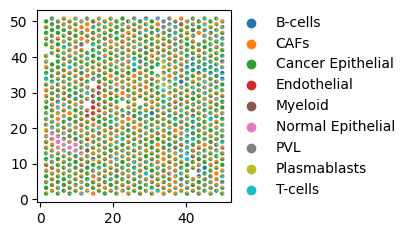

In [57]:
plot_spot_scatterpie(
    obj=st_samples[0][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    size=10,
    edgecolor="none")
plt.show()

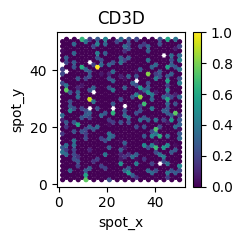

In [61]:
plot_gene_scatter(
    data=st_samples[0][1],
    obj=st_samples[0][0],
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    label='spot',
    normalize=True,
    x="spot_x",
    y="spot_y",
    show_gene="CD3D",
    colormap='viridis',
    size=7.5,
    alpha=1
)
plt.show()

In [40]:
st_samples[1][0]

,spot,spot_x,spot_y
0,spot_1,1.612903,1.612903
0,spot_2,1.612903,3.225806
0,spot_3,1.612903,4.838710
0,spot_4,1.612903,6.451613
0,spot_5,1.612903,8.064516
...,...,...,...
0,spot_957,50.000000,43.548387
0,spot_958,50.000000,45.161290
0,spot_959,50.000000,46.774194
0,spot_960,50.000000,48.387097


In [64]:
# function to simulate ST data from scRNA-seq reference data
def generate_highseg_spatial_cite(model, sc_adata, cell_type_profiles, num_samples=5, generate_cell_num=5000, spatial_size=50, num_proteins=100, num_ct_proteins=2):
    np.random.seed(412)
    
    # Init sample lists
    sc_samples = []
    st_samples = []
    cite_seq_samples = []
    
    # Number of spatial patterns (updated to include 5 new PVL-specific patterns)
    num_patterns = 25  
    shape_list = ['Oval'] * num_patterns
    ring_purity_list = [0.9, 0.8, 0.7, 0.9, 0.6, 0.8, 0.7, 0.9, 0.8, 0.6, 
                        0.7, 0.8, 0.9, 0.7, 0.8, 0.9, 0.8, 0.7, 0.8, 0.6,
                        0.85, 0.75, 0.65, 0.80, 0.70]  # Added PVL-specific purities
    ring_celltype_list = [
        ['Cancer Epithelial', 'T-cells'], ['Cancer Epithelial', 'CAFs'], 
        ['Cancer Epithelial', 'B-cells'], ['Cancer Epithelial', 'Plasmablasts'], 
        ['Cancer Epithelial', 'Myeloid'], ['Cancer Epithelial', 'Endothelial'], 
        ['Cancer Epithelial', 'Normal Epithelial'], ['T-cells', 'Cancer Epithelial'], 
        ['CAFs', 'Cancer Epithelial'], ['Myeloid', 'Cancer Epithelial'], 
        ['Plasmablasts', 'Cancer Epithelial'], ['B-cells', 'Cancer Epithelial'], 
        ['Endothelial', 'Cancer Epithelial'], ['Normal Epithelial', 'Cancer Epithelial'], 
        ['T-cells', 'CAFs'], ['Endothelial', 'CAFs'], ['Myeloid', 'Plasmablasts'], 
        ['B-cells', 'Endothelial'], ['Normal Epithelial', 'T-cells'], ['Cancer Epithelial', 'B-cells'],
        # Added PVL-specific patterns
        ['PVL', 'Cancer Epithelial'], ['PVL', 'T-cells'], ['PVL', 'Endothelial'], 
        ['PVL', 'CAFs'], ['PVL', 'Myeloid']
    ]
    infiltration_celltype_list = [
        ['T-cells', 'Endothelial'], ['T-cells', 'CAFs'], ['T-cells', 'B-cells'], 
        ['Plasmablasts', 'Myeloid'], ['Endothelial', 'Normal Epithelial'], 
        ['Myeloid', 'Cancer Epithelial'], ['CAFs', 'Plasmablasts'], 
        ['T-cells', 'Normal Epithelial'], ['Endothelial', 'B-cells'], 
        ['Myeloid', 'CAFs'], ['T-cells', 'Cancer Epithelial'], ['Endothelial', 'Myeloid'], 
        ['Plasmablasts', 'Normal Epithelial'], ['CAFs', 'B-cells'], ['T-cells', 'Plasmablasts'], 
        ['Endothelial', 'Cancer Epithelial'], ['Normal Epithelial', 'T-cells'], 
        ['CAFs', 'B-cells'], ['T-cells', 'Normal Epithelial'], ['Myeloid', 'Endothelial'],
        # Added PVL-specific interactions
        ['PVL', 'Endothelial'], ['PVL', 'T-cells'], ['PVL', 'CAFs'], 
        ['PVL', 'Myeloid'], ['PVL', 'B-cells']
    ]
    infiltration_prop_list = [[0.9, 0.1]] * num_patterns  # Proportions remain consistent
    
    background_celltype = ['Endothelial', 'T-cells', 'PVL']
    background_prop = [0.5, 0.3, 0.2]

    center_x_list = np.random.randint(0, 50, num_patterns).tolist()
    center_y_list = np.random.randint(0, 50, num_patterns).tolist()
    a_list = np.random.uniform(5, 15, num_patterns).tolist()
    b_list = np.random.uniform(5, 15, num_patterns).tolist()
    theta_list = np.random.uniform(0, np.pi, num_patterns).tolist()
    ring_width_list = [[np.random.uniform(1, 5)] for _ in range(num_patterns)]

    # generate lists of simulated samples
    for i in range(num_samples):
        center_x_list = np.random.randint(0, 60, size=num_patterns).tolist()
        center_y_list = np.random.randint(0, 60, size=num_patterns).tolist()
        theta_list = [np.random.uniform(0, 2 * np.pi) for _ in range(num_patterns)]
        seed = 412 + i # different (non-random) seed for each sample

        sc_adata.obs['Cell_type'] = sc_adata.obs['celltype']
        sc_adata.obs['Cell']      = sc_adata.obs['X']

        # generate spatial patterns for each sample
        sc_meta, sc_data = model.generate_pattern_custom_ring(
            sc_adata = sc_adata,
            generate_cell_num = generate_cell_num,
            celltype_key = 'Cell_type',
            cell_key = 'Cell',
            set_seed = True,
            seed = seed,
            select_celltype=['T-cells', 'Endothelial', 'Cancer Epithelial', 'CAFs', 
                     'B-cells', 'Myeloid', 'Plasmablasts', 'Normal Epithelial', 'PVL'],
            spatial_size=spatial_size,
            shape_list=shape_list,
            ring_purity_list=ring_purity_list,
            ring_celltype_list=ring_celltype_list,
            infiltration_celltype_list=infiltration_celltype_list,
            infiltration_prop_list=infiltration_prop_list,
            background_celltype=background_celltype,
            background_prop=background_prop,
            center_x_list=center_x_list,
            center_y_list=center_y_list,
            a_list=a_list,
            b_list=b_list,
            theta_list=theta_list,
            ring_width_list=ring_width_list,
            hidden_size=128,
            load_path='/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth',
            used_device='cuda'
        )

        # save single-cell resolution data to csv
        sc_meta.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/high_seg/SC_sim/Wu_SC_{i}_meta.csv")
        sc_data.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/high_seg/SC_sim/Wu_SC_{i}_data.csv")
        sc_samples.append((sc_meta, sc_data))

        # generate spot-level information for samples
        st_data, st_meta, st_index = model.generate_spot_data_random(
            generate_sc_data=sc_data,
            generate_sc_meta=sc_meta,
            platform='Visium',
            gene_type='whole',
            n_cell=5
        )

        # Calculate cell type proportions
        st_prop = calculate_spot_prop(
            obj=st_index,
            cell_id='Cell',
            label='Cell_type',
            spot_id='spot'
        )

        # Add missing cell types to proportions
        all_cell_types = ['T-cells', 'Endothelial', 'Cancer Epithelial', 'CAFs', 
                     'B-cells', 'Myeloid', 'Plasmablasts', 'Normal Epithelial', 'PVL']
        
        # Loop through each cell type and add missing ones with 0s
        for cell_type in all_cell_types:
            if cell_type not in st_prop.columns:
                # Create a Series of 0s with the same length as the number of rows in prop_1
                zeros_series = pd.Series([0.0] * len(st_prop), index=st_prop.index, dtype=float)
                # Insert the new column before 'spot_x'
                st_prop.insert(st_prop.columns.get_loc('spot_x'), cell_type, zeros_series)
                
        # write simulated spatial data to csv
        st_meta.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/high_seg/ST_sim/Wu_ST_{i}_meta.csv")
        st_data.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/high_seg/ST_sim/Wu_ST_{i}_data.csv")
        st_index.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/high_seg/ST_sim/Wu_ST_{i}_index.csv")
        st_prop.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/high_seg/ST_sim/Wu_ST_{i}_prop.csv")
        st_samples.append((st_meta, st_data, st_index, st_prop))

        # simulate CITE-seq data for each sample, passing cell_type_profiles as a parameter
        cite_seq_data = simulate_cite_seq_data(
            st_index, 
            st_prop,
            num_proteins=num_proteins, 
            num_ct_proteins=num_ct_proteins,
            cell_type_profiles=cell_type_profiles
        )
        cite_seq_data.to_csv(f"/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/high_seg/CITE_sim/Wu_CITE_{i}_data.csv")
        cite_seq_samples.append(cite_seq_data)

    return sc_samples, st_samples, cite_seq_samples


In [65]:
cell_type_profiles = {
    "B-cells": {
        "Major": ["B-cells_Protein_1", "B-cells_Protein_2"]
    },
    "CAFs": {
        "Major": ["CAFs_Protein_1", "CAFs_Protein_2"]
    },
    "Cancer Epithelial": {
        "Major": ["Cancer Epithelial_Protein_1", "Cancer Epithelial_Protein_2"]
    },
    "Endothelial": {
        "Major": ["Endothelial_Protein_1", "Endothelial_Protein_2"]
    },
    "Myeloid": {
        "Major": ["Myeloid_Protein_1", "Myeloid_Protein_2"]
    },
    "Normal Epithelial": {
        "Major": ["Normal Epithelial_Protein_1", "Normal Epithelial_Protein_2"]
    },
    "PVL": {
        "Major": ["PVL_Protein_1", "PVL_Protein_2"]
    },
    "Plasmablasts": {
        "Major": ["Plasmablasts_Protein_1", "Plasmablasts_Protein_2"]
    },
    "T-cells": {
        "Major": ["T-cells_Protein_1", "T-cells_Protein_2"]
    }
}

# generating simulated spatial data
highseg_sc_samples, highseg_st_samples, highseg_cite_seq_samples = generate_highseg_spatial_cite(
    model, 
    sc_adata, 
    num_samples=5,
    cell_type_profiles=cell_type_profiles
)

generating structured immune ring spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:00<00:00, 12593.68it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating structured immune ring spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:00<00:00, 12680.72it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating structured immune ring spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 2: 100%|██████████| 5000/5000 [00:01<00:00, 4808.97it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating structured immune ring spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:00<00:00, 12685.51it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...
generating structured immune ring spatial patterns...
generating by the targeted proportion of cell types...
loading model from /bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/models/Wu_scCube_large.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 5000/5000 [00:00<00:00, 12543.42it/s]


generated done!
data have been prepared!
generating spot-based ST data with 5 cells per spot...
generating with the spot layout and neighborhood structure of Visium (hex)...
generating with whole genes...


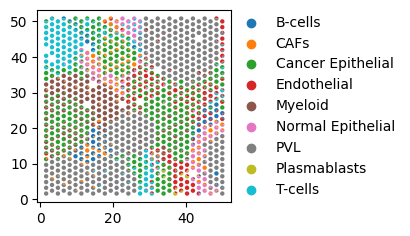

In [66]:
plot_spot_scatterpie(
    obj=highseg_st_samples[0][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    size=10,
    edgecolor="none")
plt.show()

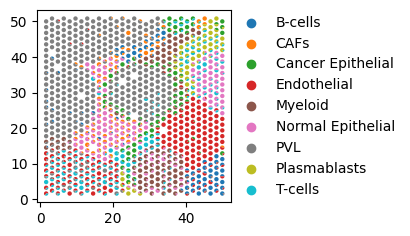

In [67]:
plot_spot_scatterpie(
    obj=highseg_st_samples[1][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    size=10,
    edgecolor="none")
plt.show()

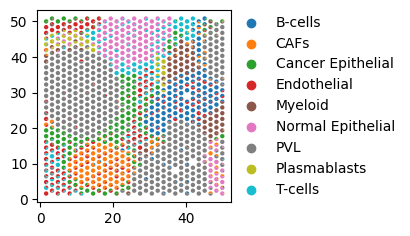

In [68]:
plot_spot_scatterpie(
    obj=highseg_st_samples[2][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    size=10,
    edgecolor="none")
plt.show()

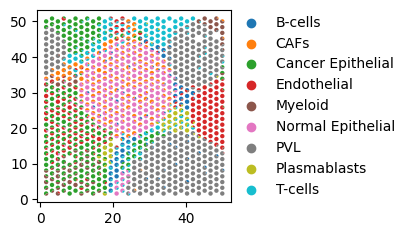

In [69]:
plot_spot_scatterpie(
    obj=highseg_st_samples[3][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    size=10,
    edgecolor="none")
plt.show()

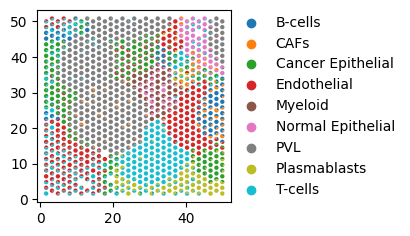

In [70]:
plot_spot_scatterpie(
    obj=highseg_st_samples[4][3],
    figwidth=2.5,
    figheight=2.5,
    x="spot_x",
    y="spot_y",
    palette = cell_type_colors,
    res=50,
    size=10,
    edgecolor="none")
plt.show()

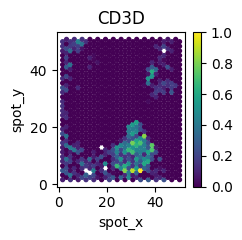

In [71]:
plot_gene_scatter(
    data=highseg_st_samples[4][1],
    obj=highseg_st_samples[4][0],
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    label='spot',
    normalize=True,
    x="spot_x",
    y="spot_y",
    show_gene="CD3D",
    colormap='viridis',
    size=7.5,
    alpha=1
)
plt.show()